In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [10]:
from scipy.signal import savgol_filter, detrend, find_peaks
from scipy.special import voigt_profile, wofz
from scipy.stats import cauchy, norm
from sklearn.ensemble import IsolationForest
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
from lmfit.models import ExponentialModel, VoigtModel

In [11]:
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, spectral_normalization, spectral_cut

In [12]:
# sns.set_style('whitegrid')
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 12

<Axes: >

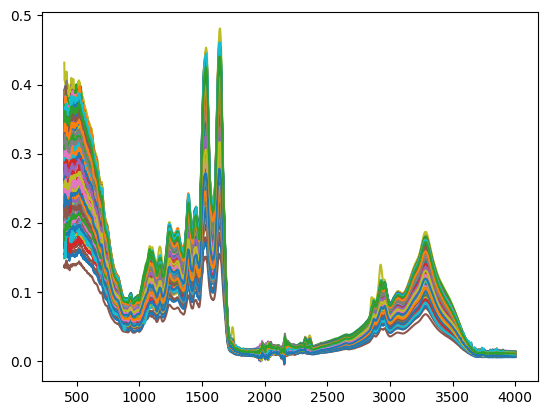

In [13]:
domain = pd.read_csv('../data/domain.csv')
df = pd.read_csv('../data/dataset.csv')
df = df.drop(columns='years')
X = df.drop(columns='HbA1c')
y = df['HbA1c']
X.columns = np.ravel(domain)
X.T.plot(legend=False)

(array([ 49., 206.,  75.,  31.,  20.,  12.,  14.,   3.,   1.,   2.]),
 array([ 3.57 ,  4.693,  5.816,  6.939,  8.062,  9.185, 10.308, 11.431,
        12.554, 13.677, 14.8  ]),
 <BarContainer object of 10 artists>)

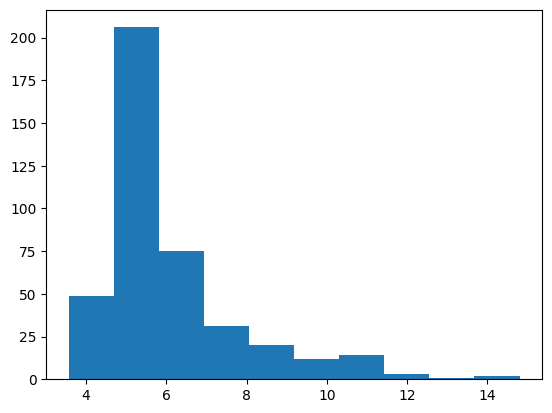

In [14]:
plt.hist(y)

# Notation

## Normal (gaussian) distribution
$$f(x) = \frac{1}{\sigma\sqrt{2 \pi}} e^{-\frac{1}{2} (\frac{x - \mu}{\sigma})^2 } \text{  Normalized to (-1, 1) range and AUC = 1}$$
$$f(x) = A_0 + A e^{-\frac{(x - x_0)^2}{2 \sigma^2}}$$

## Cauchy distribution

$$g(x) = A_0 + A \frac{\gamma^2}{\gamma^2 + (x - x_0)^2}$$

## 
$$V(x; x_0, \sigma, \gamma, A_0, A) = A_0 + \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{\infty} e^{-\frac{(x - x')^2}{2\sigma^2}} \frac{\gamma}{\pi((x' - x_0)^2 + \gamma^2)} dx'$$


In [15]:
def gaussian(x, A0, A, x0, sigma):
    """
    Calculate the Gaussian distribution.

    Parameters:
        x (float or array_like): The value(s) at which to evaluate the distribution.
        A0 (float): The offset of the Gaussian.
        A (float): The amplitude of the Gaussian.
        x0 (float): The center of the Gaussian.
        sigma (float): The standard deviation (σ) of the Gaussian.

    Returns:
        float or array_like: The value(s) of the Gaussian distribution at the given point(s) x.
    """
    return A0 + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def cauchy_distribution(x, A0, A, x0, gamma):
    """
    Calculate the Cauchy distribution.

    Parameters:
        x (float or array_like): The value(s) at which to evaluate the distribution.
        A0 (float): The offset of the Cauchy distribution.
        A (float): The amplitude of the Cauchy distribution.
        x0 (float): The center of the Cauchy distribution.
        gamma (float): The scale parameter of the Cauchy distribution.

    Returns:
        float or array_like: The value(s) of the Cauchy distribution at the given point(s) x.
    """
    return A0 + A * gamma**2 / ( gamma**2 + ( x - x0 )**2)

def voigt_profile(x, x0, sigma, gamma):
    """
    Calculate the Voigt profile (gaussian and cauchy distribution convolution)

    Parameters:
        x (float or array_like): The value(s) at which to evaluate the profile.
        x0 (float): The center of the profile.
        sigma (float): The standard deviation (σ) of the Gaussian component.
        gamma (float): The full width at half maximum (FWHM) of the Lorentzian component.

    Returns:
        float or array_like: The value(s) of the Voigt profile at the given point(s) x.
    """
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return np.real(wofz(z)).astype(float) / (sigma * np.sqrt(2 * np.pi))

def voigt(x, x0, A0, A, sigma, gamma):
    """
    Calculate the Voigt profile (gaussian and cauchy distribution convolution)

    Parameters:
        x (float or array_like): The value(s) at which to evaluate the profile.
        x0 (float): The center of the profile.
        A0 (float): The offset of the Voigt profile.
        A (float): The amplitude of the Voigt profile.
        sigma (float): The standard deviation (σ) of the Gaussian component.
        gamma (float): The full width at half maximum (FWHM) of the Lorentzian component.

    Returns:
        float or array_like: The value(s) of the Voigt profile at the given point(s) x.
    """
    return A0 + A * voigt_profile(x, x0, sigma, gamma)


gaussian_vec = np.vectorize(gaussian)
cauchy_distribution_vec = np.vectorize(cauchy_distribution)
voigt = np.vectorize(voigt)

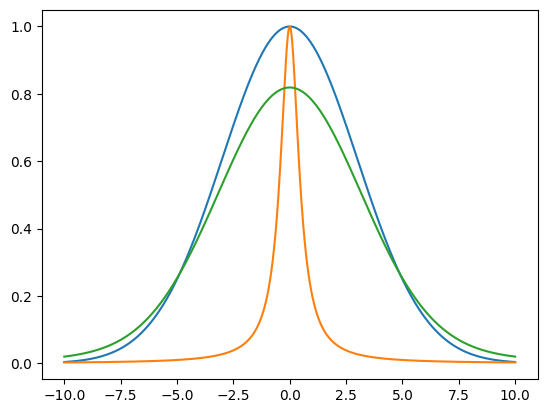

In [16]:
x_range = np.linspace(-10, 10, 1000)

gauss = gaussian_vec(x_range, 0, 1, 0, 3)
cauchy = cauchy_distribution_vec(x_range, 0, 1, 0, 0.5)
vgt = voigt(x_range, x0=0, A0=0, A=7, gamma=0.5, sigma=3)

plt.plot(x_range, gauss)
plt.plot(x_range, cauchy)
plt.plot(x_range, vgt)

In [17]:
class VoigtFit:
    def __init__(self):
        pass

    def fit(self, x_values, y_values):
        
        self.peaks, _ = find_peaks(y_values, prominence=0.001, width=4)
        self.x_values = x_values
        self.y_values = y_values
        
        params_dict = self._create_params(x_values, y_values, peaks)
        
        composite_model = None
        model_names = []
        
        for i, peak in enumerate(peaks):
            model_name = f"v{i+1}"
            voigt_model = VoigtModel(prefix=model_name)
            if composite_model is None:
                composite_model = voigt_model
            else:
                composite_model += voigt_model
            model_names.append(model_name)
    
        self.params = composite_model.make_params(**params_dict)
        self.result = composite_model.fit(y_values, self.params, x=x_values)
        
        return 

    def _create_params(self, x_values, y_values, peaks):
        params = {}
    
        for i, peak in enumerate(peaks):
            params.update({
                f"v{i+1}amplitude": dict(value=1, vary=True),
                f"v{i+1}center": dict(value=x_values[peak], vary=True),
                f"v{i+1}sigma": dict(value=1, min=0, vary=True),
                f"v{i+1}gamma": dict(value=1, min=0, vary=True)
            })
        return params

    def plot_results(self, show_comp=False):
        plt.figure(figsize=(8, 5))
        print(self.peaks)
        plt.plot(self.x_values, self.y_values, color='k', linewidth=1, label='true values')
        plt.scatter(self.x_values[self.peaks], self.y_values[self.peaks], alpha=1, color='r')

        x_range = np.arange(min(self.x_values), max(self.x_values))
        
        comp = self.result.eval_components(x=x_range)

        if show_comp:
            for key, values in comp.items():
                plt.plot(x_range, values, linestyle='--')
        
        plt.plot(self.x_values, self.result.best_fit, label='best fit')
        plt.legend()

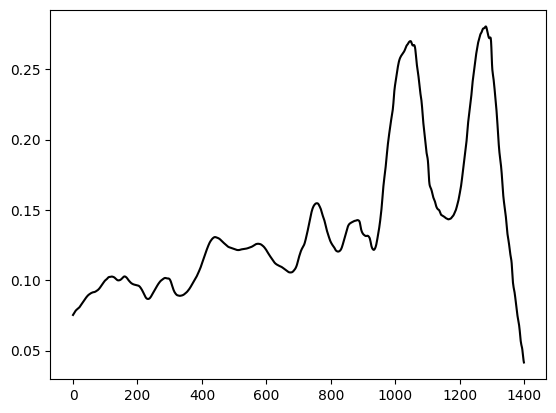

In [18]:
sample = X.iloc[0, 1300:2700]
plt.plot(np.arange(len(sample)), sample.to_numpy(), color='k', linewidth=1.5)
#peaks, _ = find_peaks(sample, prominence=0.01)
#plt.scatter(sample.index[peaks], sample.iloc[peaks], alpha=1, color='r')
#plt.xlim([1370, 1800])

In [19]:
def create_params(array: pd.Series, peaks):
    params = {}

    for i, peak in enumerate(peaks):
        params.update({
            f"v{i+1}amplitude": dict(value=1, vary=True),
            f"v{i+1}center": dict(value=array.index[peak], vary=True),
            f"v{i+1}sigma": dict(value=1, min=0, vary=True),
            f"v{i+1}gamma": dict(value=1, min=0, vary=True)
        })
    
    return params

def fit_voigt(array: pd.Series, peaks):

    def create_params(array: pd.Series, peaks):
        params = {}
    
        for i, peak in enumerate(peaks):
            params.update({
                f"v{i+1}amplitude": dict(value=1, vary=True),
                f"v{i+1}center": dict(value=array.index[peak], vary=True),
                f"v{i+1}sigma": dict(value=1, min=0, vary=True),
                f"v{i+1}gamma": dict(value=1, min=0, vary=True)
            })
        
        return params
    
    params_dict = create_params(array, peaks)
    
    composite_model = None
    model_names = []
    
    for i, peak in enumerate(peaks):
        model_name = f"v{i+1}"
        voigt_model = VoigtModel(prefix=model_name)
        if composite_model is None:
            composite_model = voigt_model
        else:
            composite_model += voigt_model
        model_names.append(model_name)

    params = composite_model.make_params(**params_dict)
    result = composite_model.fit(array, params, x=array.index)

    plt.figure(figsize=(8, 5))
    plt.plot(sample, color='k', linewidth=1, label='true values')
    plt.scatter(sample.index[peaks], sample.iloc[peaks], alpha=1, color='r')

    x_range = np.arange(min(array.index), max(array.index))
    comp = result.eval_components(x=x_range)
    
    for key, values in comp.items():
        plt.plot(x_range, values, linestyle='--')
    
    plt.plot(sample.index, result.best_fit, label='best fit')
    #plt.plot(sample.index, result.init_fit, label='initial fit', linestyle='--')
    plt.legend()
    #plt.savefig("voigt_fit_1.png")

    fitted_params = result.params

    for param_name, param in fitted_params.items():
        print(param_name, param.value)
        
    return 

In [20]:
# %%time
# sample = X.iloc[1, 900:2750]
# fit_voigt(sample)